In [59]:
pip install kaggle


In [61]:
import os
import kaggle
import zipfile
import pandas as pd

os.environ['KAGGLE_CONFIG_DIR'] = "/path/to/kaggle.json"  

# Dataset URL from Kaggle (use the dataset slug)
dataset_url = 'berkanoztas/synthetic-transaction-monitoring-dataset-aml'  
download_path = 'synthetic-transaction-monitoring-dataset-aml.zip' 

# Download the dataset
print("Downloading dataset...")
kaggle.api.dataset_download_files(dataset_url, path='.', unzip=False)

# Check if the file exists after download
if os.path.exists(download_path):
    print(f"Dataset downloaded successfully: {download_path}")
else:
    print(f"Download failed. Could not find {download_path}.")

# Unzip the downloaded dataset if it exists
if os.path.exists(download_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(".")  # Extract to the current directory
    print("Extraction completed.")

    # Load the dataset into a pandas DataFrame
    df = pd.read_csv("SAML-D.csv")  # Adjust filename if necessary
    print(df.head())  # Show the first few rows of the dataset
else:
    print("Dataset zip file not found. Please check the download process.")



Dataset URL: https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml
Dataset downloaded successfully: synthetic-transaction-monitoring-dataset-aml.zip
Extracting dataset...
Extraction completed.
       Time        Date  Sender_account  Receiver_account    Amount  \
0  10:35:19  2022-10-07      8724731955        2769355426   1459.15   
1  10:35:20  2022-10-07      1491989064        8401255335   6019.64   
2  10:35:20  2022-10-07       287305149        4404767002  14328.44   
3  10:35:21  2022-10-07      5376652437        9600420220  11895.00   
4  10:35:21  2022-10-07      9614186178        3803336972    115.25   

  Payment_currency Received_currency Sender_bank_location  \
0        UK pounds         UK pounds                   UK   
1        UK pounds            Dirham                   UK   
2        UK pounds         UK pounds                   UK   
3        UK pounds         UK pounds                   UK   
4        UK pounds         UK pounds    

In [9]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [11]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64


In [13]:
# Define the categorical and numerical features
categorical_features = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
                        'Receiver_bank_location', 'Payment_type']
numerical_features = ['Amount']

In [15]:
# Split the dataset into features (X) and target (y)
X = df[categorical_features + numerical_features]
y = df['Is_laundering']

In [17]:
# Split the data into training and testing sets (60-40 split)
random_state_value = 35
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state_value)

In [19]:
# Predicting Transactions Using Logistic Regression 

In [21]:
# Preprocessor: OneHotEncoder for categorical features and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [23]:
# Fit and transform the training data using the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)

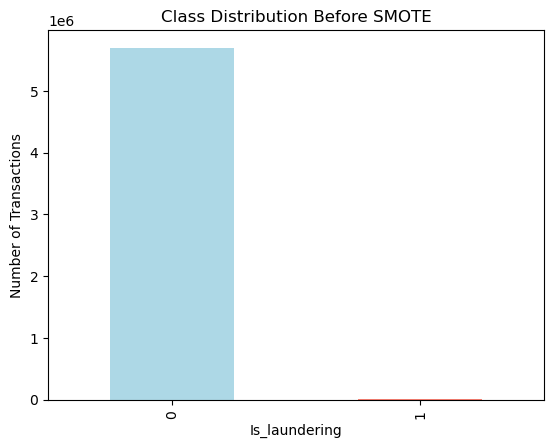

In [24]:
# Plot class distribution before SMOTE
y_train.value_counts().plot(kind='bar', title='Class Distribution Before SMOTE', color=['lightblue', 'salmon'])
plt.ylabel('Number of Transactions')
plt.show()

In [27]:
# Apply SMOTE for balancing the dataset (only on the transformed training set)
smote = SMOTE(random_state=random_state_value, sampling_strategy=0.5)  # Balance the minority class more
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

In [29]:
# Visualize class distribution after applying SMOTE
print("Class distribution after SMOTE:")
print(y_train_res.value_counts())

Class distribution after SMOTE:
Is_laundering
0    5697098
1    2848549
Name: count, dtype: int64


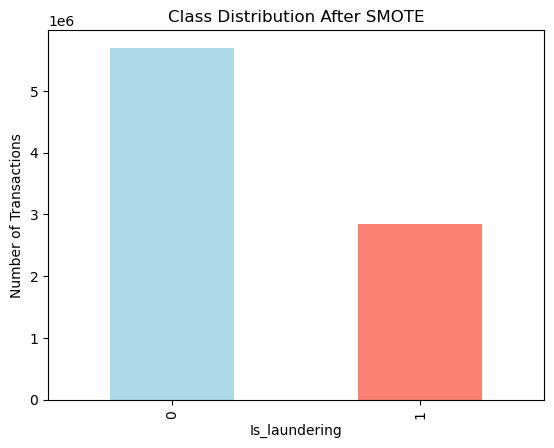

In [31]:
# Plot after SMOTE
y_train_res.value_counts().plot(kind='bar', title='Class Distribution After SMOTE', color=['lightblue', 'salmon'])
plt.ylabel('Number of Transactions')
plt.show()


In [33]:
# **Logistic Regression with Class Weights**
# Train a Logistic Regression model with class_weight='balanced'
model = LogisticRegression(random_state=random_state_value, 
                           class_weight='balanced', 
                           solver='liblinear',  # Use 'liblinear' solver
                           max_iter=1000)

model.fit(X_train_res, y_train_res)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=35,
                   solver='liblinear')

In [35]:
# Predict on the test set
X_test_processed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_processed)

In [37]:
# Evaluate the Logistic Regression model
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      0.83      0.91   3797881
           1       0.00      0.62      0.01      4060

    accuracy                           0.83   3801941
   macro avg       0.50      0.72      0.46   3801941
weighted avg       1.00      0.83      0.91   3801941



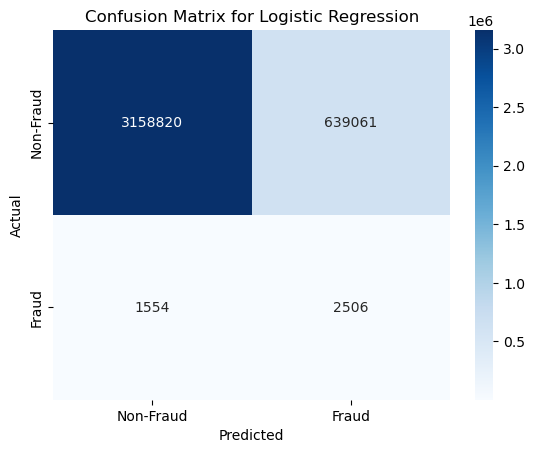

In [39]:
# Confusion Matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

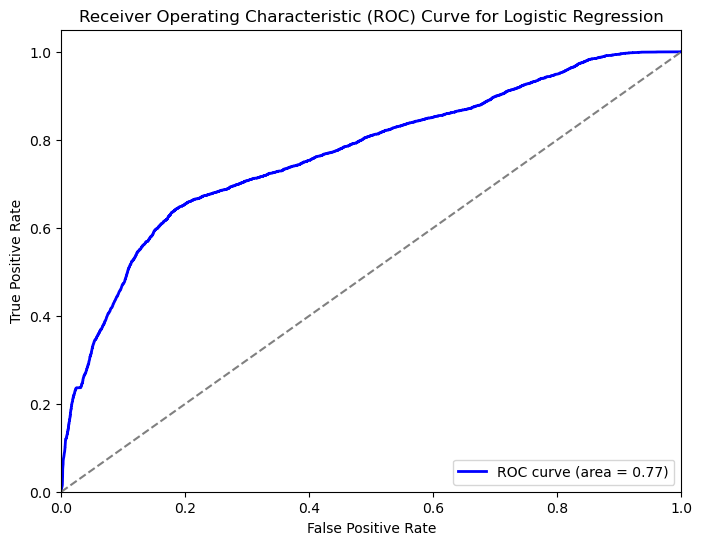

In [41]:
# ROC Curve and AUC for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_processed)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Save the best model's predictions to a new CSV file (Logistic Regression)
new_data_path = 'D:/M.Sc Data Science/TM_Project/Test_transactionsdata.csv'
new_data = pd.read_csv(new_data_path)

In [45]:
# Display the first few rows to understand the structure
print(new_data.head())

    Time        Date      Sender_account    Receiver_account  Amount  \
0  00:56   3/26/2023  CGSW53767242388496  NBGQ59770348247710    7370   
1  03:34  10/27/2020  SMLH28710122691669  UTZH24808613171274     960   
2  15:29   1/20/2023  OQIR01845146270482  QWIN77378263982146    5490   
3  08:06  12-04-2022  QDUJ89325288095701  KZQI04499727875588    5291   
4  21:22   2/18/2025  LZJH03911718227824  MOKG39636057662702    5834   

  Payment_currency Received_currency Sender_bank_location  \
0              INR               INR          Pollardfort   
1              AUD               EUR          Port Dennis   
2              GBP               USD       Johnsonborough   
3              USD               AUD        Port Jameston   
4              INR               GBP           Sarahhaven   

  Receiver_bank_location     Payment_type  Is_laundering  
0                Shawton  Online Transfer            NaN  
1          New Ericburgh  Online Transfer            NaN  
2             West Sara

In [47]:
# Preprocess the new data using the same fitted preprocessor (with the encoder trained on the training data)
X_new = new_data[categorical_features + numerical_features]

In [49]:
# Transform the new data using the preprocessor (the same one fitted on the training data)
X_new_processed = preprocessor.transform(X_new)

In [51]:
# Make predictions using the trained Logistic Regression model
y_new_pred = model.predict(X_new_processed)

In [53]:
# Add the predictions to the new data# Preprocess the new data using the same fitted preprocessor (with the encoder trained on the training data)
X_new = new_data[categorical_features + numerical_features]
new_data['Predicted_Is_laundering'] = y_new_pred

In [55]:
# Save the new data with predictions to a CSV file
output_file_path = 'D:/M.Sc Data Science/TM_Project/transactions_predictions_using_Logistic.csv'
new_data.to_csv(output_file_path, index=False)

In [57]:
# Display the results
print("Predictions saved successfully!")
print(new_data.head())

Predictions saved successfully!
    Time        Date      Sender_account    Receiver_account  Amount  \
0  00:56   3/26/2023  CGSW53767242388496  NBGQ59770348247710    7370   
1  03:34  10/27/2020  SMLH28710122691669  UTZH24808613171274     960   
2  15:29   1/20/2023  OQIR01845146270482  QWIN77378263982146    5490   
3  08:06  12-04-2022  QDUJ89325288095701  KZQI04499727875588    5291   
4  21:22   2/18/2025  LZJH03911718227824  MOKG39636057662702    5834   

  Payment_currency Received_currency Sender_bank_location  \
0              INR               INR          Pollardfort   
1              AUD               EUR          Port Dennis   
2              GBP               USD       Johnsonborough   
3              USD               AUD        Port Jameston   
4              INR               GBP           Sarahhaven   

  Receiver_bank_location     Payment_type  Is_laundering  \
0                Shawton  Online Transfer            NaN   
1          New Ericburgh  Online Transfer       